<a href="https://colab.research.google.com/github/Valiev-Koyiljon/Face-mask-detection-Pytorch/blob/main/Facemask_detection_last1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facemask Detection



Title: Real-time Face Mask Detection using Pre-trained ResNet Model

Description:
The project aims to detect whether a person is wearing a face mask or not in real-time using computer vision techniques and a pre-trained ResNet model. The system captures video frames from a webcam, applies face detection to locate faces in the frames, and then utilizes a deep learning model to classify each detected face as either wearing a mask or not.

The project consists of two main parts:

1. Training the Face Mask Detection Model:
   - The project starts with training a face mask detection model using a pre-trained ResNet model.
   - A dataset of 100 images is used for training the model, where each image is labeled as either having a person wearing a mask or not.
   - The pre-trained ResNet model, specifically ResNet-50, is employed as a feature extractor, and the final fully connected layer is modified to have two output neurons representing mask and no-mask classes.
   - The model is trained using the dataset, and the training process involves optimizing the model's parameters using an Adam optimizer and cross-entropy loss.
   - After training, the model is saved to a file for later use during real-time face mask detection.

2. Real-time Face Mask Detection:
   - Once the model is trained and saved, the project focuses on real-time face mask detection using OpenCV.
   - The system captures video frames from the webcam and applies face detection using the Haar cascade classifier provided by OpenCV.
   - For each detected face, the model is utilized to classify whether the person is wearing a mask or not by passing the face through the trained model.
   - The result is then displayed on the screen by drawing a rectangle around the face and adding a label indicating whether the person is wearing a mask or not.
   - The process continues in real-time, detecting faces and updating the display accordingly.
   - The system allows the user to exit the application by pressing the 'q' key.

The project combines deep learning techniques with computer vision to address the important task of face mask detection. It can be applied in various settings, such as public spaces, workplaces, and healthcare facilities, to help ensure adherence to face mask policies and promote public health and safety.

#Deep Learning. Part I

In [1]:
# Mounting google drive to colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile


#  path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready.zip"
destination_folder = "/content/drive/MyDrive/Colab Notebooks/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


print("Folder extraction completed.")

Folder extraction completed.


In [52]:
# Import necessary packages and libraries
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models




In [53]:
# changing the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
#  FaceMaskDataset class for training, validation, and test data
class FaceMaskDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        return image, label

In [55]:
# FaceMaskDetector class
class FaceMaskDetector:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model(model_path).to(self.device)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_model(self, model_path):
        model = models.resnet50(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 2)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.eval()
        return model

    def detect(self, frame):
        frame = self.transform(frame).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(frame)
        probabilities = torch.softmax(output, dim=1)[0]
        mask_probability = probabilities[1].item()
        no_mask_probability = probabilities[0].item()
        label = "Mask" if mask_probability > no_mask_probability else "No Mask"
        return label

In [56]:
# The training parameters
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready/train"
val_data_dir = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready/val"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/mask_images_ready/test"
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Final_FaceMask_detection_model.pt"
batch_size = 16
num_epochs = 12

In [57]:
# Load the training data
train_image_paths = []
train_labels = []

for folder_name in os.listdir(train_data_dir):
    folder_path = os.path.join(train_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"): 
                file_path = os.path.join(folder_path, file_name)
                train_image_paths.append(file_path)
                train_labels.append(1 if folder_name == "1" else 0)

In [58]:
# Load the validation data
val_image_paths = []
val_labels = []

for folder_name in os.listdir(val_data_dir):
    folder_path = os.path.join(val_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(folder_path, file_name)
                val_image_paths.append(file_path)
                val_labels.append(1 if folder_name == "1" else 0)

In [59]:
# Load the test data
test_image_paths = []
test_labels = []

for folder_name in os.listdir(test_data_dir):
    folder_path = os.path.join(test_data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(folder_path, file_name)
                test_image_paths.append(file_path)
                test_labels.append(1 if folder_name == "1" else 0)

In [60]:
# FaceMaskDataset class for training, validation, and test data
train_dataset = FaceMaskDataset(train_image_paths, train_labels, transform=transforms.ToTensor())
val_dataset = FaceMaskDataset(val_image_paths, val_labels, transform=transforms.ToTensor())
test_dataset = FaceMaskDataset(test_image_paths, test_labels, transform=transforms.ToTensor())


In [61]:
#  training, validation, and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
# Function to show a batch of images during training
import matplotlib.pyplot as plt

def show_batch(images, labels):
    fig, axes = plt.subplots(figsize=(12, 6), ncols=4)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title("With Mask" if labels[i] == 1 else "Without Mask")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [63]:
# FaceMaskModel class
class FaceMaskModel(nn.Module):
    def __init__(self):
        super(FaceMaskModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.model(x)



# FaceMaskModel class
model = FaceMaskModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
# the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Move the model to the device
model = model.to(device)

Epoch 1/12
Train Loss: 0.0040 | Train Accuracy: 100.00%
Val Loss: 0.0004 | Val Accuracy: 100.00%
-------------------------------
Epoch 2/12
Train Loss: 0.0005 | Train Accuracy: 100.00%
Val Loss: 0.0004 | Val Accuracy: 100.00%
-------------------------------
Epoch 3/12
Train Loss: 0.0010 | Train Accuracy: 100.00%
Val Loss: 0.0005 | Val Accuracy: 100.00%
-------------------------------
Epoch 4/12
Train Loss: 0.4237 | Train Accuracy: 91.67%
Val Loss: 0.0130 | Val Accuracy: 100.00%
-------------------------------
Epoch 5/12
Train Loss: 0.0156 | Train Accuracy: 100.00%
Val Loss: 0.0056 | Val Accuracy: 100.00%
-------------------------------
Epoch 6/12
Train Loss: 0.0285 | Train Accuracy: 100.00%
Val Loss: 0.0126 | Val Accuracy: 100.00%
-------------------------------
Epoch 7/12
Train Loss: 0.0317 | Train Accuracy: 98.61%
Val Loss: 0.0216 | Val Accuracy: 100.00%
-------------------------------
Epoch 8/12
Train Loss: 0.0511 | Train Accuracy: 98.61%
Val Loss: 0.1000 | Val Accuracy: 92.86%
----

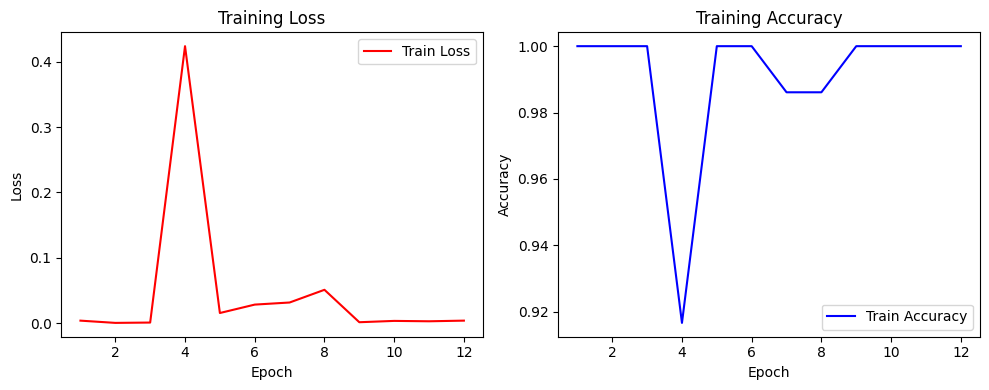

In [68]:
# list to save the train loss and accuracy for plotting
train_loss_values = []
train_accuracy_values = []



# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()


    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    train_loss_values.append(train_loss)  # Append train loss value to the list
    train_accuracy_values.append(train_accuracy)  # Append train accuracy value to the list

    # Model evaluation on the validation data
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_accuracy = val_correct / val_total
    val_loss = val_loss / len(val_loader)


    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy*100:.2f}%")
    print("-------------------------------")


#Plotting train loss and accuracy

# list of epoch numbers
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))


# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train Loss', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
# plt.show()

# Plot train accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, label='Train Accuracy', color="blue")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
# plt.show()


plt.tight_layout()
plt.show()

In [69]:
 # Save the trained model
torch.save(model.state_dict(), model_save_path)

# Model evaluation on test data
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = test_correct / test_total
test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")



# save the model one more time after checking good accuracy
torch.save(model.state_dict(), model_save_path)

Test Loss: 0.0014 | Test Accuracy: 100.00%


For downloading our model from google colab noteb, we will use the below codes

In [ ]:
from google.colab import files

model_path = model_save_path

files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Checking our model by uploading pictures


In [71]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from google.colab import files



class FaceMaskModel(nn.Module):
    def __init__(self):
        super(FaceMaskModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.model(x)



# calling our model
model = FaceMaskModel()




# the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])



uploaded = files.upload()



# Getting the uploaded image file
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)



# Preprocess the image
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension




# face mask detection
with torch.no_grad():
    model.eval()
    output = model(input_batch)




class_probabilities = torch.softmax(output, dim=1)
mask_probability = class_probabilities[0, 1].item() 


threshold = 0.5  #treshold
if mask_probability > threshold:
    print("Face mask detected with probability:", mask_probability)
else:
    print("No face mask detected with probability:", 1 - mask_probability)


Saving facemmask.jpg to facemmask.jpg
No face mask detected with probability: 0.6588020920753479
